# DoRA: Weight-Decomposed LowRank Adaptation (DoRA)

More optimal way to fine-tune models. The reason is that if we use the Adam optimizer (requires two copies of the weights for first and second moments), we need to store 3 copies of the model's weights. For example with llama, at 7b parameters, it'd turn into 21b prameters. At 4 bytes per parameter, that's 84GB of memory just for the weights. Additionally, we'd have to keep track of gradients and activations, which would require even more memory. By decomposing the weights into a low-rank and a sparse part, we can use consumer GPUs to fine-tune large models.

DoRA seems to outperform LoRA by quite a bit:

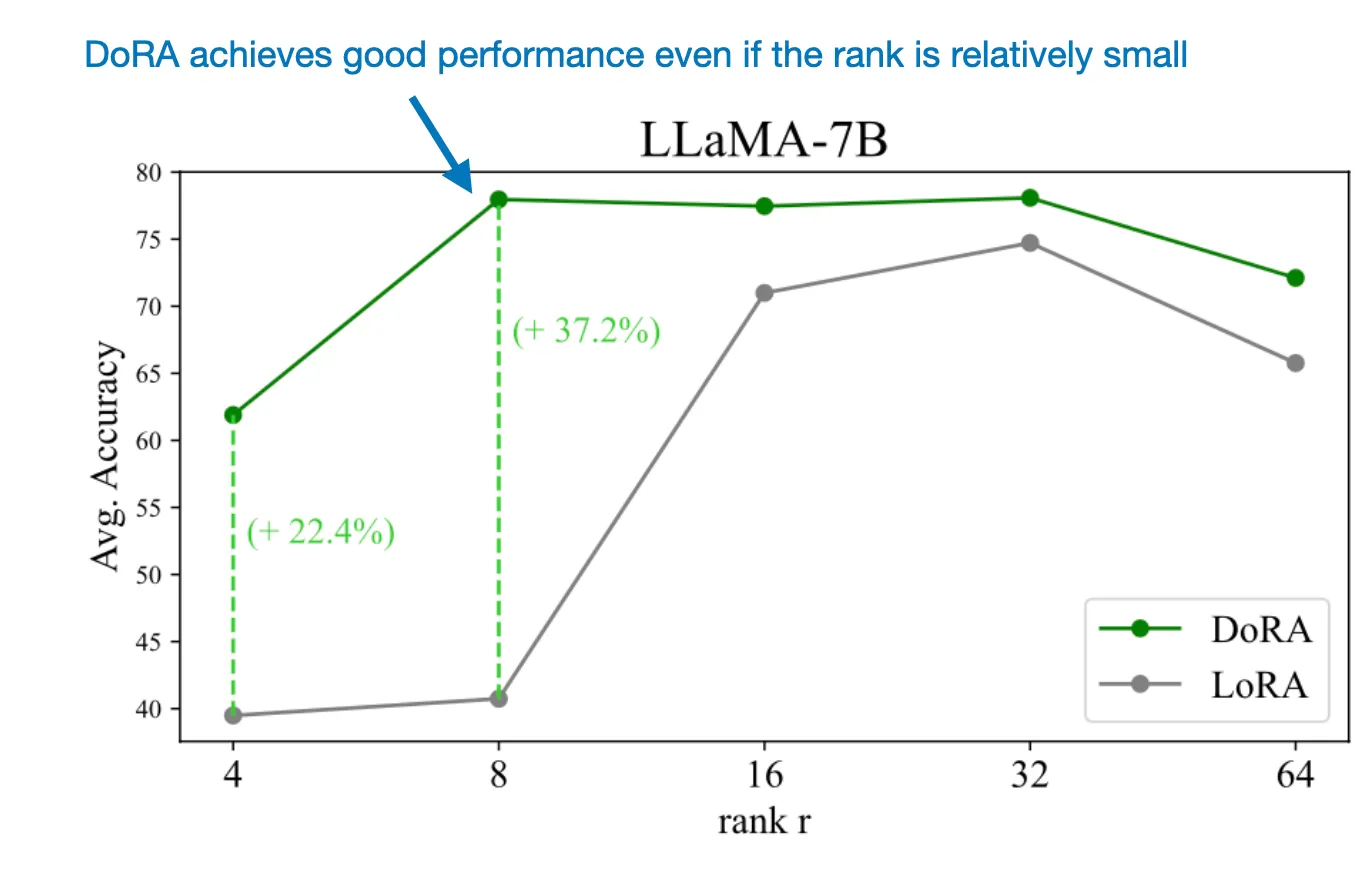

Why we need DoRA:

According to the paper, DoRa better mimics fine tuning.

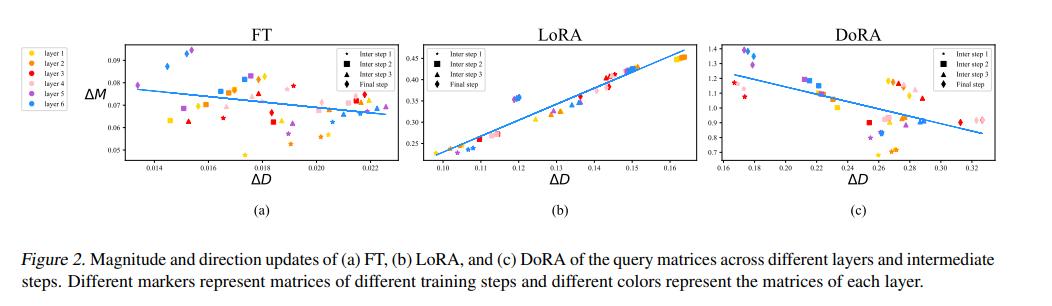


## References
[DoRA: Weight-Decomposed Low-Rank Adaptation](https://www.youtube.com/watch?v=m7KQdGSr0Dg&ab_channel=GabrielMongaras)

[Improving LoRA: Implementing Weight-Decomposed Low-Rank Adaptation (DoRA) from Scratch](https://magazine.sebastianraschka.com/p/lora-and-dora-from-scratch)

[DoRA: Weight-Decomposed Low-Rank Adaptation](https://arxiv.org/abs/2402.09353)

In [12]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
torch.manual_seed(0)

### LoRA Recap

In [3]:
class LoraLayer(nn.Module):
    def __init__(self, layer, rank, alpha):
        super().__init__()
        self.features_in = layer.in_features
        self.features_out = layer.out_features
        self.lora_A = nn.Parameter(torch.zeros((rank, self.features_out)))
        self.lora_B = nn.Parameter(torch.zeros((self.features_in, rank)))
        nn.init.normal_(self.lora_A, mean=0, std=1)
        self.scale = alpha / rank

    def forward(self, x):
        x = (x @ self.lora_B @ self.lora_A) * self.scale
        return x

In [4]:
class LinearWithLoRA(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoraLayer(linear, rank, alpha,)
    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [5]:
def freeze_linear_layers(model):
    for child in model.children():
        if isinstance(child, nn.Linear):
            for param in child.parameters():
                param.requires_grad = False
        else:
            # Recursively freeze linear layers in children modules
            freeze_linear_layers(child)

In [6]:
x = torch.randn((1, 10))
layer = nn.Linear(10, 2)
print("Original output:", layer(x))
layer_lora_1 = LinearWithLoRA(layer, rank=2, alpha=4)
print("LoRA output:", layer_lora_1(x))

Original output: tensor([[0.4465, 0.5755]], grad_fn=<AddmmBackward0>)
LoRA output: tensor([[0.4465, 0.5755]], grad_fn=<AddBackward0>)


## Understanding Weight-Decomposed Low-Rank Adaptation (DoRA)

DoRA (Weight-Decomposed Low-Rank Adaptation) can be seen as an improvement or extension of LoRA that is built on top of it, and we can now easily adapt some of our previous code to implement DoRA.

DoRA can be described in two steps, where the first step is to decompose a pretrained weight matrix into a magnitude vector (m) and a directional matrix (V). The second step is applying LoRA to the directional matrix V and training the magnitude vector m separately.

The decomposition into magnitude and directional components is inspired by the mathematical principle that any vector can be represented as the product of its magnitude (a scalar value indicating its length) and its direction (a unit vector indicating its orientation in space).

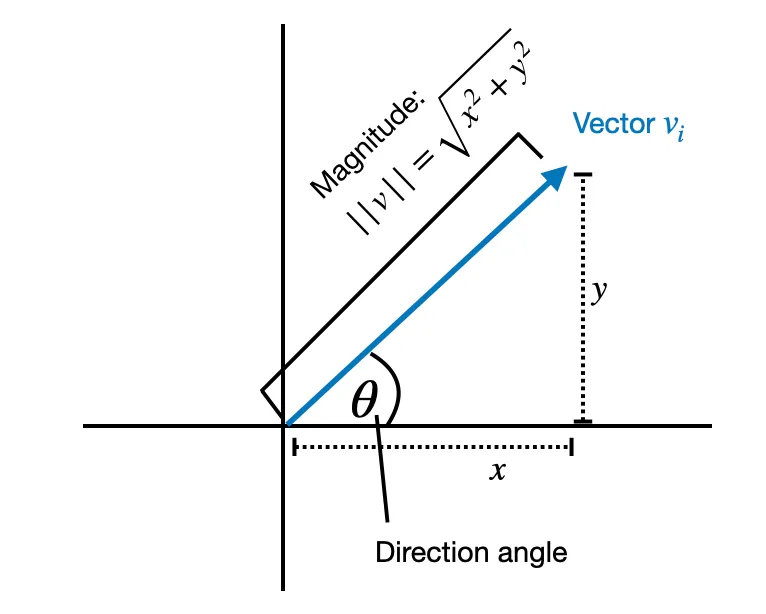

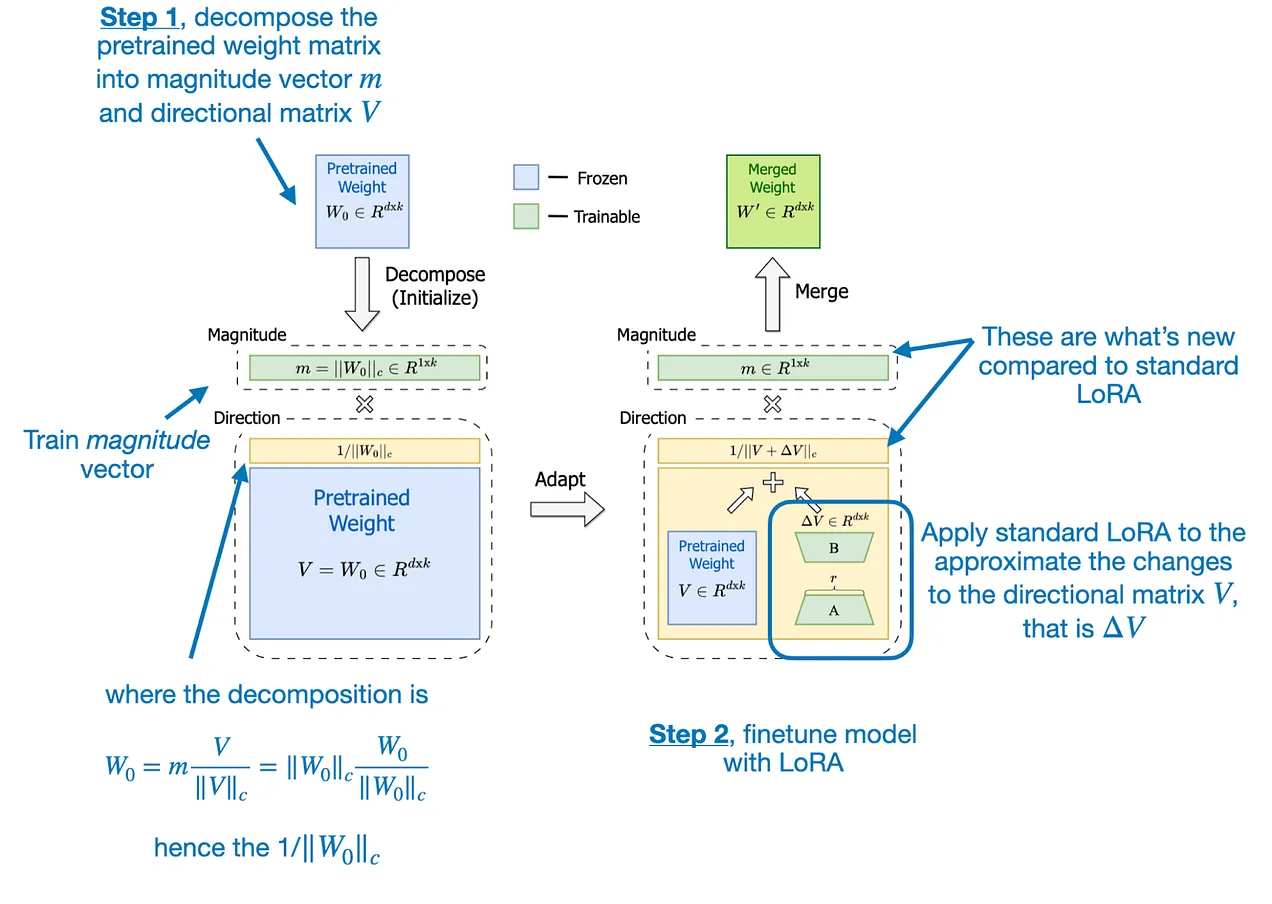

The magnitude vector m adds 0.01% more parameters if DoRA is compared to LoRA. However, across both LLM and vision transformer benchmarks, they found that DoRA even outperforms LoRA if the DoRA rank is halved, for instance, when DoRA only uses half the parameters of regular LoRA, as shown in the performance comparison below.

LoRA requires careful tuning of the rank to optimize performance: Practical Tips for Finetuning LLMs Using LoRA (Low-Rank Adaptation)
 
https://magazine.sebastianraschka.com/p/practical-tips-for-finetuning-llms

In [7]:
class LinearDora(nn.Module):
    def __init__(self, layer, rank, alpha):
        super().__init__()
        self.layer = layer
        self.lora = LoraLayer(layer, rank, alpha,)
        self.m = nn.Parameter(self.layer.weight.norm(p=2, dim=0, keepdim=True))

    def forward(self, x):
        # pulling the forward pass of lora
        lora = (self.lora.lora_B @ self.lora.lora_A).view(self.layer.weight.shape)
        v_numerator = self.layer.weight + (lora * self.lora.scale)
        v_norm_denominator = v_numerator.norm(p=2, dim=0, keepdim=True)
        directional_component = v_numerator / v_norm_denominator
        new_weight = self.m * directional_component
        # x @ W + b
        return F.linear(x, new_weight, self.layer.bias)

In [8]:
layer_dora_1 = LinearDora(layer, rank=2, alpha=4)
print("DoRA output:", layer_dora_1(x))

DoRA output: tensor([[0.4465, 0.5755]], grad_fn=<AddmmBackward0>)


## Example of How to Implement DoRA

In [9]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, num_features, 
        num_hidden_1, num_hidden_2, num_classes):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_features, num_hidden_1),
            nn.ReLU(),
            nn.Linear(num_hidden_1, num_hidden_2),
            nn.ReLU(),
            nn.Linear(num_hidden_2, num_classes)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

num_features = 10
num_hidden_1 = 20
num_hidden_2 = 10
num_classes = 2

model = MultilayerPerceptron(
    num_features=num_features,
    num_hidden_1=num_hidden_1,
    num_hidden_2=num_hidden_2, 
    num_classes=num_classes
)

print(model)

MultilayerPerceptron(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
)


### LoRA Example

In [13]:
model_lora = copy.deepcopy(model)

# modify the model to use LoRA
model_lora.layers[0] = LinearWithLoRA(model_lora.layers[0], rank=4, alpha=8)
model_lora.layers[2] = LinearWithLoRA(model_lora.layers[2], rank=4, alpha=8)
model_lora.layers[4] = LinearWithLoRA(model_lora.layers[4], rank=4, alpha=8)

print(model)

MultilayerPerceptron(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [ ]:
freeze_linear_layers(model_lora)
for name, param in model_lora.named_parameters():
    print(f"{name}: {param.requires_grad}")

### DoRA Example

In [17]:
model.layers[0] = LinearDora(model.layers[0], rank=4, alpha=8)
model.layers[2] = LinearDora(model.layers[2], rank=4, alpha=8)
model.layers[4] = LinearDora(model.layers[4], rank=4, alpha=8)

print(model)

MultilayerPerceptron(
  (layers): Sequential(
    (0): LinearDora(
      (layer): Linear(in_features=10, out_features=20, bias=True)
      (lora): LoraLayer()
    )
    (1): ReLU()
    (2): LinearDora(
      (layer): Linear(in_features=20, out_features=10, bias=True)
      (lora): LoraLayer()
    )
    (3): ReLU()
    (4): LinearDora(
      (layer): Linear(in_features=10, out_features=2, bias=True)
      (lora): LoraLayer()
    )
  )
)


In [18]:
# notice the "m" parameters in the model
freeze_linear_layers(model)
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

layers.0.m: True
layers.0.layer.weight: False
layers.0.layer.bias: False
layers.0.lora.lora_A: True
layers.0.lora.lora_B: True
layers.2.m: True
layers.2.layer.weight: False
layers.2.layer.bias: False
layers.2.lora.lora_A: True
layers.2.lora.lora_B: True
layers.4.m: True
layers.4.layer.weight: False
layers.4.layer.bias: False
layers.4.lora.lora_A: True
layers.4.lora.lora_B: True


In [19]:
model(x)

tensor([[-0.1447,  0.1464]], grad_fn=<AddmmBackward0>)

## Why Does this this technique work?

LoRA shows us that we can fine-tune large models on consumer GPUs by decomposing the weights into a low-rank and a sparse part. DoRA suggests that we can improve the performance of LoRA by decomposing the weights into a magnitude vector and a directional matrix, and training them separately.

How far is the the magnitude of the current magnitude vector from the optimal magnitude vector? How far is the current directional matrix from the optimal directional matrix, using cosine similarity?

In LoRA, the relationship is linear and tiny variance. This doesn't mimic fine-tuning very well.

In DoRA the change in direction changes, the magnitude decreases. This is an inverse relationship. High variance

For training, the denominator should be decoupled from the gradient graph so that magnitudes don't explode.